In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

c:\Users\am_la\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            #nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            #nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 2

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Force CPU
device = torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [5]:
# Load
PATH_enc = 'encoder_conv_autoenc.pt'
PATH_dec = 'decoder_conv_autoenc.pt'
encoder.load_state_dict(torch.load(PATH_enc))
encoder.eval()
decoder.load_state_dict(torch.load(PATH_dec))
decoder.eval()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [6]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.03932034969329834

tensor([-0.0239, -0.0432])
tensor([0.9008, 1.2393])


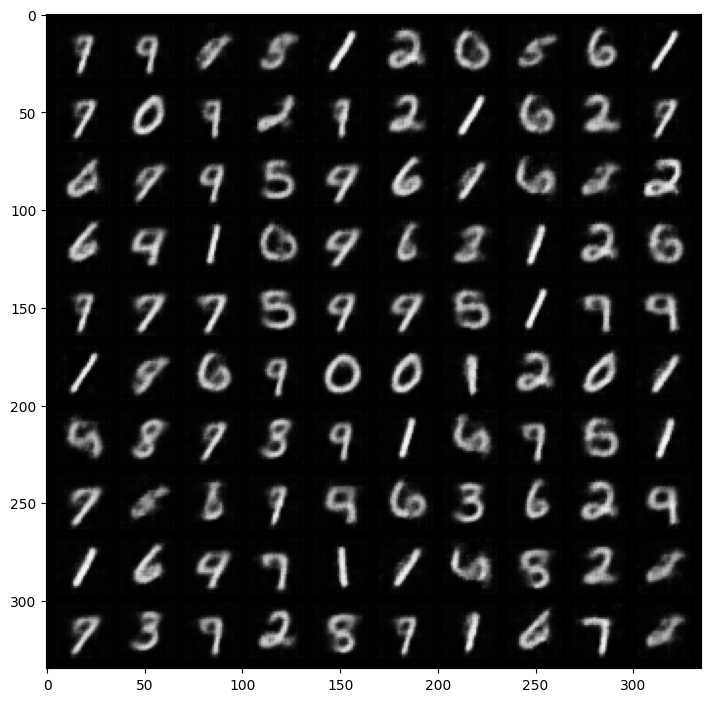

In [6]:
#generate samples from latnt code and calculate mean and std
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean
    #print(latent)
    #print(latent.shape)

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [8]:
from tqdm import tqdm

In [9]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:05<00:00, 1913.49it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,0.240591,0.286738,7
1,-0.607497,-0.340900,2
2,0.161667,2.805163,1
3,-0.585463,-1.994725,0
4,0.570041,-0.280448,4
...,...,...,...
9995,-1.036740,-0.070023,2
9996,-0.075183,-0.534253,3
9997,0.057888,0.203255,4
9998,-0.553849,0.327204,5


In [10]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [8]:
#Let us take a uniform grid on the latent space. Note that here d=2. The bounds for the grid can be taken from 3 sigma rule. 
#We will take 2 sigmas however
numsteps = 10
xs = torch.linspace(mean[0]-2*std[0], mean[0]+2*std[0], steps = numsteps)
ys = torch.linspace(mean[1]-2*std[1], mean[1]+2*std[1], steps = numsteps)
uniform_grid = torch.cartesian_prod(xs,ys)

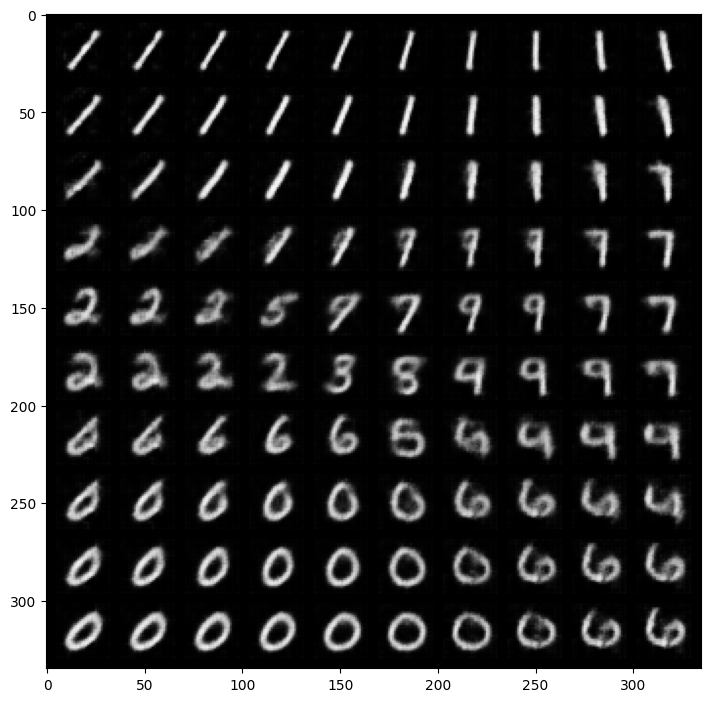

torch.Size([100, 2])
torch.Size([100, 1, 28, 28])


In [9]:
# True Manifold plot
truegrid = torch.cartesian_prod(ys,- xs)
latent = - truegrid.roll(1,1)
latent = latent.to(device)
img_recon = decoder(latent)
img_recon = img_recon.cpu()

fig, ax  = plt.subplots(figsize=(20, 8.5))
img_grid = torchvision.utils.make_grid(img_recon[:100],10,5)
show_image(img_grid.detach())
plt.show()
print(latent.shape)
print(img_recon.shape)

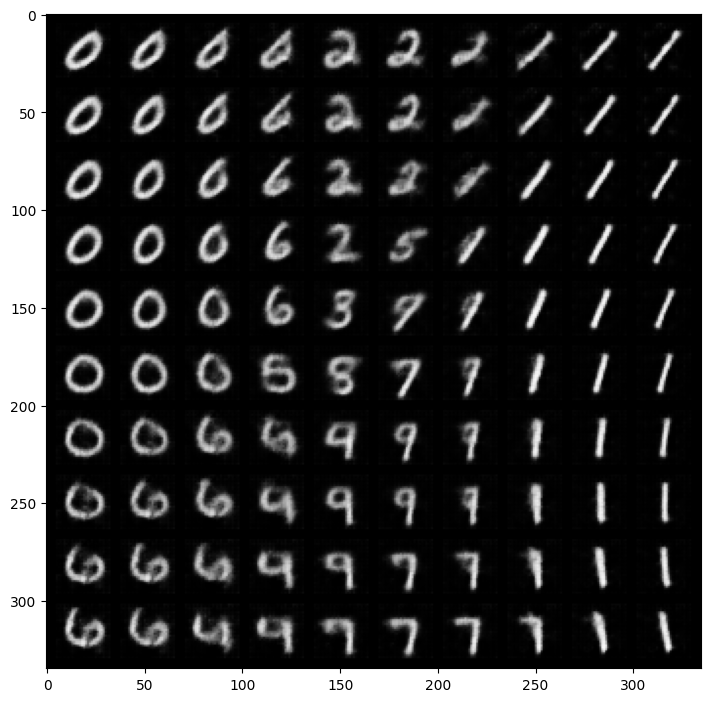

torch.Size([100, 2])
torch.Size([100, 1, 28, 28])


In [10]:
#Manifold plot
latent = uniform_grid
latent = latent.to(device)
img_recon = decoder(latent)
img_recon = img_recon.cpu()

fig, ax  = plt.subplots(figsize=(20, 8.5))
img_grid = torchvision.utils.make_grid(img_recon[:100],10,5)
show_image(img_grid.detach())
plt.show()
print(latent.shape)
print(img_recon.shape)

# Slow way to compute metric (with loops)

In [11]:
#let us do it in a slow way first. Making separate computations at every point of a grid

def my_g_upd(u, hx, hy): #this gives metric at point u with steps hx and hy
    dpsidx = (decoder(u + torch.tensor([[0.0 + hx, 0.0]])) - decoder(u + torch.tensor([[0.0 - hx, 0.0]])))/(2*hx)
    dpsidy = (decoder(u + torch.tensor([[0.0, 0.0 + hy]])) - decoder(u + torch.tensor([[0.0, 0.0 - hy]])))/(2*hy)
    my_metric = torch.tensor([[(dpsidx*dpsidx).sum(),(dpsidx*dpsidy).sum()],
                             [(dpsidx*dpsidy).sum(),(dpsidy*dpsidy).sum()]])
    return my_metric

In [12]:
#this is done in a bad way
numsteps = 100
xs = np.linspace(float(mean[0]-2*std[0]), float(mean[0]+2*std[0]), numsteps)
ys = np.linspace(float(mean[1]-2*std[1]), float(mean[1]+2*std[1]), numsteps)
#grid = meshgid(xs,ys)
#h = float((xs[numsteps-1] - xs[0])/numsteps)


In [13]:
hx = float((xs[numsteps-1] - xs[0])/(numsteps-1))
hy = float((ys[numsteps-1] - ys[0])/(numsteps-1))

In [14]:
hx

0.03811896208560828

In [15]:
hy

0.05637203563343395

In [16]:
FrobNormGrid = torch.zeros(numsteps, numsteps)
MetricSlow = torch.zeros(numsteps*numsteps,2,2)

In [17]:
#this is done in a bad way

#i = 0
j = 0
for y in ys:
    i = 0
    #j = 0
    for x in xs:
        #FrobNormGrid[i, j] = torch.linalg.norm(my_g(torch.tensor([[float(x), float(y)]]),h))
        FrobNormGrid[i, j] = torch.linalg.norm(my_g_upd(torch.tensor([[float(x), float(y)]]),hx,hy))
        MetricSlow[i*numsteps + j] = my_g_upd(torch.tensor([[float(x), float(y)]]),hx,hy)
        i += 1
        #j+=1
    #i+=1
    j += 1
print(FrobNormGrid)

tensor([[28.9825, 29.4970, 30.5944,  ..., 34.9493, 34.4889, 33.3282],
        [30.7563, 29.8679, 30.0991,  ..., 34.8958, 32.5249, 31.7656],
        [33.6069, 31.7578, 30.7833,  ..., 31.9592, 30.7204, 30.0174],
        ...,
        [31.9917, 32.2335, 27.9783,  ..., 32.3446, 32.7198, 32.6581],
        [31.2555, 28.1738, 26.9511,  ..., 30.5094, 32.0826, 30.6490],
        [28.7628, 26.5227, 26.3212,  ..., 29.9682, 30.8898, 30.7850]])


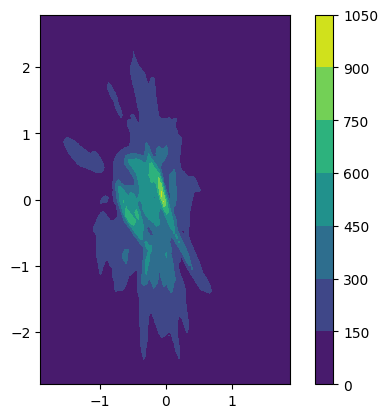

In [18]:
#Heat map of the frobenius norm
#h = plt.contourf(xs[1:-1], ys[1:-1], FrobNormGrid[1:-1,1:-1])
h = plt.contourf(xs, ys, FrobNormGrid)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [19]:
# Let us rewrite the metric function so that it would take the grid of points and give out the metric evaluated on a grid

# Differentiation with the help of torch.roll

In [20]:
#what if we differentiate all at once? This should be faster
numsteps = 10
xs = torch.linspace(mean[0]-2*std[0], mean[0]+2*std[0], steps = numsteps)
ys = torch.linspace(mean[1]-2*std[1], mean[1]+2*std[1], steps = numsteps)
uniform_grid = torch.cartesian_prod(xs,ys)

latent1 = uniform_grid

latent1 = latent1.to(device)
toto = decoder(latent1)
print( toto.shape )

torch.Size([100, 1, 28, 28])


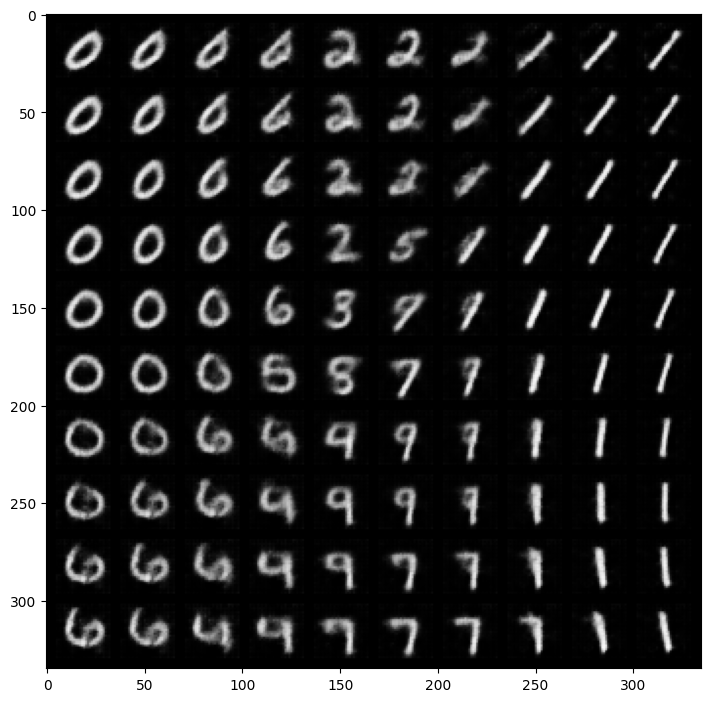

In [21]:
#manifold plot

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(toto[:100],10,5).detach())
plt.show()

In [22]:
# shift along x axis
toto_shiftx = toto.roll(-1,0)

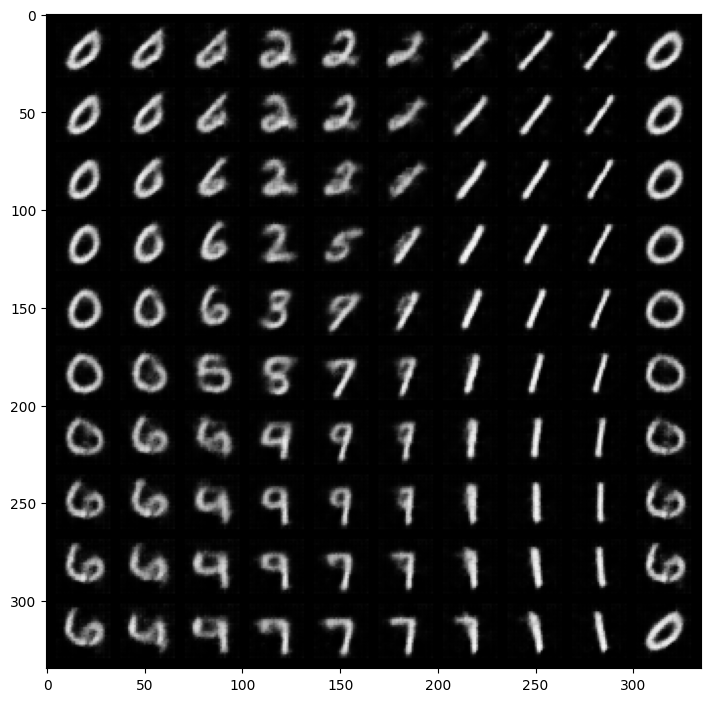

In [23]:
#manifold plot with a shift wrt to x axis

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(toto_shiftx[:100],10,5).detach())
plt.show()

# Fast way to compute metric on a grid over the latent space (torch.roll)

In [7]:
#Let us take a uniform grid on the latent space. Note that here d=2. The bounds for the grid can be taken from 3 sigma rule. 
#We will take 2 sigmas however
numsteps = 100
xs = torch.linspace(mean[0]-2*std[0], mean[0]+2*std[0], steps = numsteps)
ys = torch.linspace(mean[1]-2*std[1], mean[1]+2*std[1], steps = numsteps)
#uniform_grid = torch.cartesian_prod(xs,ys)

In [8]:
# true grid starts from left bottom corner. x is the first to increase
tgrid = torch.cartesian_prod(ys, xs)
tgrid = tgrid.roll(1,1)

In [9]:
#metric on a grid
def g(grid):
    numsteps = int(np.sqrt(grid.shape[0]))
    
    hx = float(abs((grid[numsteps**2 - 1] - grid[0])[0]))/(numsteps - 1)
    hy = float(abs((grid[numsteps**2 - 1] - grid[0])[1]))/(numsteps - 1)
    
    latent = grid
    latent = latent.to(device)
    psi = decoder(latent)
    psi_next_x =  psi.roll(-1,0)
    psi_prev_x =  psi.roll(1,0)
    psi_next_y =  psi.roll(-numsteps,0)
    psi_prev_y =  psi.roll(numsteps,0)
    
    dpsidx = (psi_next_x - psi_prev_x)/(2*hx)
    dpsidy = (psi_next_y - psi_prev_y)/(2*hy)
    
    metric = torch.cat(((dpsidx*dpsidx).sum((1,2,3)),(dpsidx*dpsidy).sum((1,2,3)),(dpsidx*dpsidy).sum((1,2,3)),(dpsidy*dpsidy).sum((1,2,3))),0)
    metric = metric.view(4, numsteps*numsteps)
    metric = metric.transpose(0, 1)
    return metric

In [10]:
# compute the grid of metric
with torch.no_grad():
    #metric = g(uniform_grid)
    metric = g(tgrid)
    metric = metric.view(numsteps*numsteps, 2, 2)

In [11]:
metric.shape

torch.Size([10000, 2, 2])

## Heatmap of frobenius norm of metric

In [14]:
# Fast computation of Frobenious norm on the grid without borders
Newfrob = metric.norm(dim=(1,2)).view(numsteps,numsteps)
Newfrob = Newfrob[1:-1,1:-1].transpose(0,1)

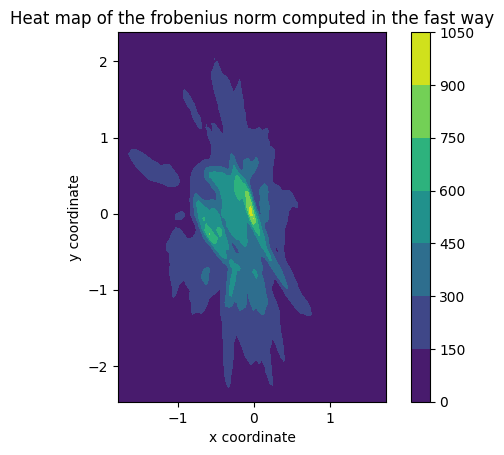

In [15]:
#Heat map of the frobenius norm
h = plt.contourf(xs[1:-1], ys[1:-1], Newfrob)
plt.title('Heat map of the frobenius norm computed in the fast way')
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.axis('scaled')
plt.colorbar()
plt.show()

### Derivatives of the metric and Christoffel symbols

In [29]:
#simultaneous differentiation on a grid with torch.roll
def diff_by_x(tensor, numsteps, h):
    psi = tensor
    psi_next_x =  psi.roll(-1,0)
    psi_prev_x =  psi.roll(1,0)
    dpsidx = (psi_next_x - psi_prev_x)/(2*h)
    return dpsidx
def diff_by_y(tensor, numsteps, h):
    psi = tensor
    psi_next_y =  psi.roll(-numsteps,0)
    psi_prev_y =  psi.roll(numsteps,0)
    dpsidy = (psi_next_y - psi_prev_y)/(2*h)
    return dpsidy
    

In [30]:
#derivatives of the metric on a grid
def dg_grid (grid): #dg
    
    numsteps = int(np.sqrt(grid.shape[0]))
    
    hx = float(abs((grid[numsteps**2 - 1] - grid[0])[0]))/(numsteps - 1)
    hy = float(abs((grid[numsteps**2 - 1] - grid[0])[1]))/(numsteps - 1)

    latent = grid
    latent = latent.to(device)
    psi = decoder(latent)
    
    dpsidx = diff_by_x(psi, numsteps, hx)
    dpsidy = diff_by_x(psi, numsteps, hy)
    dpsidx_second = diff_by_x(dpsidx, numsteps, hx)
    dpsidx_dy = diff_by_y(dpsidx, numsteps, hy)
    dpsidy_second = diff_by_y(dpsidy, numsteps, hy)
    
    #metric = torch.cat(((dpsidx*dpsidx).sum((1,2,3)),(dpsidx*dpsidy).sum((1,2,3)),
    #                  (dpsidx*dpsidy).sum((1,2,3)),(dpsidy*dpsidy).sum((1,2,3))),0)
    
    dgdx = torch.cat((2*(dpsidx*dpsidx_second).sum((1,2,3)),(dpsidx_second * dpsidy + dpsidx * dpsidx_dy).sum((1,2,3)),
                      (dpsidx_second * dpsidy + dpsidx * dpsidx_dy).sum((1,2,3)),2*(dpsidy * dpsidx_dy).sum((1,2,3))),0)
    dgdy = torch.cat((2*(dpsidx*dpsidx_dy).sum((1,2,3)),(dpsidy_second * dpsidx + dpsidy * dpsidx_dy).sum((1,2,3)),
                      (dpsidy_second * dpsidx + dpsidy * dpsidx_dy).sum((1,2,3)),2*(dpsidy*dpsidy_second).sum((1,2,3))),0)
    metric_der = torch.cat((dgdx, dgdy), 0)
    metric = metric_der
    metric = metric.view(8, numsteps*numsteps)
    metric = metric.transpose(0, 1)
    metric = metric.view(numsteps*numsteps, 2, 4)
    return metric

In [31]:
# compute the grid of metric derivatives
with torch.no_grad():
    #metric_der = dg_grid(uniform_grid)
    metric_der = dg_grid(tgrid)
    metric_der = metric_der.view(numsteps*numsteps, 2, 2, 2)


In [32]:
# This is used for making a piecewise constant metric from its evaluation on a grid
def find_nearest_index (grid, u):
    index = int(torch.min(abs(grid - u),0).indices.sum())
    #index = int((((u - tgrid[0])*numsteps/size).floor()*torch.tensor([1.,numsteps])).sum()) #thisd could be faster
    return index

In [33]:
#it finds the value on the closest node on the grid
metric_der[find_nearest_index(tgrid, torch.tensor([0,0]))]

tensor([[[-741.5704, -645.1119],
         [-645.1119, -533.3698]],

        [[-788.7712, -533.3698],
         [-533.3698, -360.6664]]])

In [34]:
#evaluation of the piecewise constant inverse of g
def g_inv (u): #inverse metric
    #index = find_nearest_index(uniform_grid, u)
    index = find_nearest_index(tgrid, u)
    A = metric[index]
    #g_inv = torch.linalg.inv(A)
    g_inv = torch.inverse(A)
    return g_inv

In [35]:
g_inv(torch.tensor([1, 1]))

tensor([[0.0400, 0.0173],
        [0.0173, 0.0566]])

In [36]:
#evaluation of the piecewise constant derivatives of g
def dg (u): #dg
    #index = find_nearest_index(uniform_grid, u)
    index = find_nearest_index(tgrid, u)
    g = metric_der[index]
    return g

In [37]:
dg(torch.tensor([0, 0]))

tensor([[[-741.5704, -645.1119],
         [-645.1119, -533.3698]],

        [[-788.7712, -533.3698],
         [-533.3698, -360.6664]]])

In [38]:
#Christoffel symbols at a point u = (x, y)
def Ch(u):
    Ch = torch.zeros((2,2,2))
    for i in range(2):
        for j in range(2):
            for l in range(2):
                for k in range(2):
                    Ch[l,i,j] += 0.5 * g_inv(u)[l,k] * (dg(u)[i,k,j] + dg(u)[j,i,k] - dg(u)[k,i,j]) #Ch^l_ij
    return Ch

In [39]:
Ch(torch.tensor([0, 0]))

tensor([[[-1.1414, -1.2140],
         [-1.2140, -0.8209]],

        [[ 0.0933,  0.0992],
         [ 0.0992,  0.0671]]])

In [40]:
#computing geodesics...
# y = [u , v]
# v := dot(u)
# dot(v)^l = Ch^l_ij * v^i * v^j
def geod(y, t):
    #u, v = y
    u = y[0:2:]
    v = y[2::]
    dudt = v
    #dvdt = torch.zeros(2)
    dvdt = np.zeros(2)
    u = torch.from_numpy(u)
    for l in range(2):
        for i in range(2):
            for j in range(2):
                dvdt[l] -= (Ch(u)[l,i,j]).numpy() * v[i] * v[j]
    dydt = np.concatenate((dudt, dvdt))
    #dydt = torch.cat((dudt, dvdt),0)
    return dydt

In [41]:
u0 = [1, 1] # initial position in local coord \phi, \theta
v0 = [-1.0, -1.0]/np.sqrt(2) # initial speed
y0 = np.concatenate((u0,v0))
#u0 = torch.tensor([0.1, 0.0]) # initial position in local coord \phi, \theta
#v0 = torch.tensor([0.0, 1.0]) # initial speed
#y0 = torch.cat((u0,v0), 0)

In [42]:
# the border of the laten space (left bottom an upper right corner)
mean - 2*std, mean + 2*std

(tensor([-1.8969, -2.7884]), tensor([1.8769, 2.7924]))

In [43]:
t = np.linspace(0, 2*np.sqrt(2), 51)
#t = torch.linspace(0, 2, steps = 21)

In [44]:
#from scipy.integrate import odeint  # for comparison
#sol = odeint(geod, y0, t)
# This shit does not work

In [45]:
def rungekutta1(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        y[i+1] = y[i] + (t[i+1] - t[i])*f(y[i], t[i], *args)
    return y


In [46]:
sol = rungekutta1(geod, y0, t)
#this does not work. Try rewriting find_index

In [47]:
sol.shape

(51, 4)

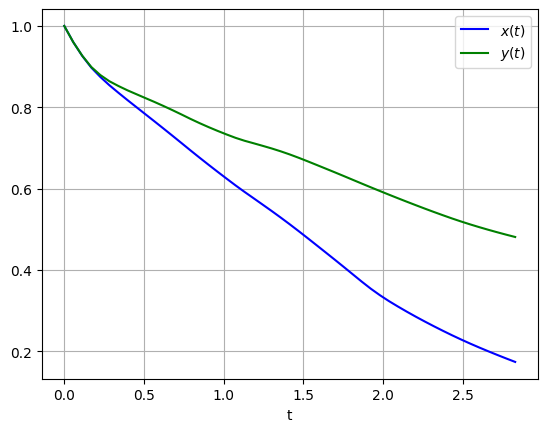

In [48]:
#draw the graphs of solutions x and y
plt.plot(t, sol[:, 0], 'b', label=r'$x(t)$')
plt.plot(t, sol[:, 1], 'g', label=r'$y(t)$')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()
#these are the local coordinates x(t) and y(t) of a geodesic evolving with time t

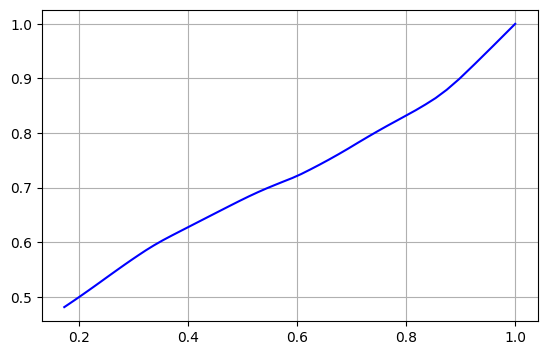

In [49]:
plt.plot(sol[:, 0],sol[:, 1], 'b', label=r'$x,y')
plt.axis('scaled')
plt.grid()
plt.show()

## Vectorized computation of geodesics (with a loop in find_indices)

In [56]:
# this could be done faster
def find_nearest_indices (grid, u):
    #this could be done more efficiently
    n = u.shape[0]
    indices = torch.zeros(n)
    for i in range(n):
        indices[i] = find_nearest_index(grid, u[i])
    indices = indices.to(torch.int64) # just some magic to make it work
    return indices

In [57]:
check = torch.tensor([[0,0],[1,0]])

In [58]:
metric.shape

torch.Size([10000, 2, 2])

In [59]:
torch.index_select(metric, 0, myindices).inverse()

tensor([[[ 0.0043, -0.0018],
         [-0.0018,  0.0023]],

        [[ 0.0283,  0.0041],
         [ 0.0041,  0.0116]]])

In [60]:
#evaluation of the piecewise constant inverse of g
def g_inv_vect (grid, u): #inverse metric
    #index = find_nearest_index(tgrid, u)
    indices = find_nearest_indices(grid, u)
    #A = metric[index]
    A = torch.index_select(metric, 0, indices)
    g_inv = torch.inverse(A)
    return g_inv

In [61]:
g_inv_vect(tgrid, check)

tensor([[[ 0.0043, -0.0018],
         [-0.0018,  0.0023]],

        [[ 0.0283,  0.0041],
         [ 0.0041,  0.0116]]])

In [62]:
#evaluation of the piecewise constant derivatives of g
def dg_vect (grid, u): #dg
    #index = find_nearest_index(uniform_grid, u)
    indices = find_nearest_indices(grid, u)
    g = torch.index_select(metric_der, 0, indices)
    return g

In [63]:
dg_vect(tgrid, check)

tensor([[[[-741.5704, -645.1119],
          [-645.1119, -533.3698]],

         [[-788.7712, -533.3698],
          [-533.3698, -360.6664]]],


        [[[ -19.1535,    5.8415],
          [   5.8415,   16.6580]],

         [[  24.6346,   16.6580],
          [  16.6580,   11.2642]]]])

In [64]:
#Christoffel symbols at a vector of n points. u has shape (n, x, y)
def Ch_vect(grid, u):
    n = u.shape[0]
    Ch = torch.zeros((n,2,2,2))
    for i in range(2):
        for j in range(2):
            for l in range(2):
                for k in range(2):
                    Ch[:,l,i,j] += 0.5 * g_inv_vect(grid, u)[:,l,k] * (dg_vect(grid, u)[:,i,k,j] + dg_vect(grid, u)[:,j,i,k] - dg_vect(grid, u)[:,k,i,j]) #Ch^l_ij
    return Ch

In [65]:
Ch_vect(tgrid, check)

tensor([[[[-1.1414, -1.2140],
          [-1.2140, -0.8209]],

         [[ 0.0933,  0.0992],
          [ 0.0992,  0.0671]]],


        [[[-0.2975,  0.3826],
          [ 0.3826,  0.2587]],

         [[-0.1141,  0.1468],
          [ 0.1468,  0.0992]]]])

In [67]:
Ch(check[1])
# just to check there is no mistake in vectorized vertion Ch_vect

tensor([[[-0.2975,  0.3826],
         [ 0.3826,  0.2587]],

        [[-0.1141,  0.1468],
         [ 0.1468,  0.0992]]])

In [152]:
# Do not do like that Ch_vect still exploits the loop in find_indices
#Ch_vect(tgrid,tgrid)

In [68]:
#computing geodesics...
# y has shape num of points, u, v
# v := dot(u)
# dot(v)^l = Ch^l_ij * v^i * v^j
def geod(y, t):
    #u, v = y
    n = y.shape[0]
    u = y[: , 0:2:]
    v = y[: , 2::]
    dudt = v
    dvdt = torch.zeros(n, 2)
    for l in range(2):
        for i in range(2):
            for j in range(2):
                dvdt[:, l] -= Ch_vect(tgrid, u)[:, l,i,j] * v[:, i] * v[:, j] #here we use Ch_vect instead od Ch
    dydt = torch.cat((dudt.T, dvdt.T)).T
    # dydt = np.concatenate((dudt, dvdt))
    return dydt

In [92]:
print(tgrid[0], tgrid[-1])

tensor([-1.8969, -2.7884]) tensor([1.8769, 2.7924])


In [74]:
u0 = torch.tensor([0.1, 0.0]) # initial position in local coord \phi, \theta
v0 = torch.tensor([0.0, 1.0]) # initial speed
y0 = torch.cat((u0,v0)).view(1,4)
t = torch.linspace(0, 1.5, steps = 31)

In [75]:
geod(y0,t)

tensor([[0.0000, 1.0000, 1.3996, 0.1173]])

In [76]:
def rungekutta_new(f, y0, t, args=()):
    nt = len(t) # number of steps in time
    # len(y0[0]) is the number of initial conditions
    # len(y0[1]) is the dimention of the state space. In our case it is 4 
    y = torch.zeros((nt, y0.shape[0],y0.shape[1]))
    y[0,:,:] = y0
    for i in range(nt - 1):
        y[i+1,:,:] = y[i,:,:] + (t[i+1] - t[i])*f(y[i,:,:], t[i], *args)
        print(y[i,:,:])
    return y

In [77]:
sol = rungekutta_new(geod, y0, t)

tensor([[0.1000, 0.0000, 0.0000, 1.0000]])
tensor([[0.1000, 0.0500, 0.0700, 1.0059]])
tensor([[0.1035, 0.1003, 0.1996, 1.1040]])
tensor([[0.1135, 0.1555, 0.0478, 1.0090]])
tensor([[0.1159, 0.2059, 0.0083, 0.9966]])
tensor([[ 0.1163,  0.2558, -0.0083,  0.9904]])
tensor([[ 0.1159,  0.3053, -0.0102,  0.9890]])
tensor([[ 1.1536e-01,  3.5474e-01, -8.1183e-04,  9.9754e-01]])
tensor([[0.1153, 0.4046, 0.0177, 1.0134]])
tensor([[0.1162, 0.4553, 0.0356, 1.0301]])
tensor([[0.1180, 0.5068, 0.0543, 1.0503]])
tensor([[0.1207, 0.5593, 0.0747, 1.0723]])
tensor([[0.1244, 0.6129, 0.1073, 1.1117]])
tensor([[0.1298, 0.6685, 0.1391, 1.1505]])
tensor([[0.1368, 0.7260, 0.1571, 1.1749]])
tensor([[0.1446, 0.7848, 0.1770, 1.2064]])
tensor([[0.1535, 0.8451, 0.2230, 1.2876]])
tensor([[0.1646, 0.9095, 0.2472, 1.3322]])
tensor([[0.1770, 0.9761, 0.2483, 1.3343]])
tensor([[0.1894, 1.0428, 0.2453, 1.3286]])
tensor([[0.2017, 1.1092, 0.2787, 1.3926]])
tensor([[0.2156, 1.1789, 0.2943, 1.4251]])
tensor([[0.2303, 1.2501, 0

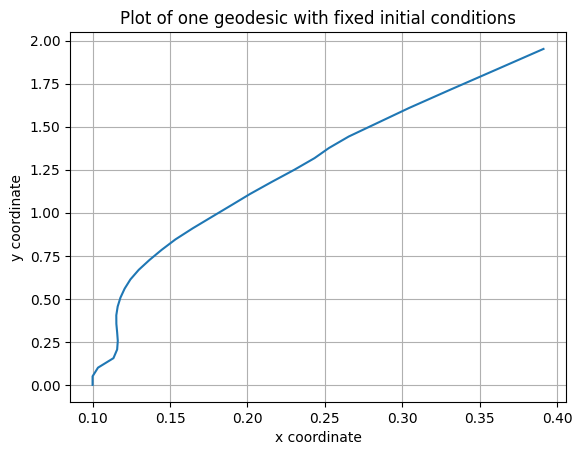

In [78]:
plt.plot(sol[:, :, 0], sol[:, :, 1])
#plt.plot(t, solrand[:, :, 1], 'g', label=r'$\theta(t)$')
#plt.legend(loc='best')
#plt.plot( sol.T )
plt.title( "Plot of one geodesic with fixed initial conditions")
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.grid()

In [93]:
init = torch.tensor([[0.1000, 0.0000, 0.0000, 1.0000], [0.1000, 0.0000, 0.2000, 0.8000]])

In [94]:
init

tensor([[0.1000, 0.0000, 0.0000, 1.0000],
        [0.1000, 0.0000, 0.2000, 0.8000]])

In [95]:
sol2 = rungekutta_new(geod, init, t)

tensor([[0.1000, 0.0000, 0.0000, 1.0000],
        [0.1000, 0.0000, 0.2000, 0.8000]])
tensor([[0.1000, 0.0500, 0.0700, 1.0059],
        [0.1100, 0.0400, 0.2812, 0.8068]])
tensor([[0.1035, 0.1003, 0.1996, 1.1040],
        [0.1241, 0.0803, 0.2224, 0.7664]])
tensor([[0.1135, 0.1555, 0.0478, 1.0090],
        [0.1352, 0.1187, 0.1670, 0.7425]])
tensor([[0.1159, 0.2059, 0.0083, 0.9966],
        [0.1435, 0.1558, 0.1384, 0.7334]])
tensor([[ 0.1163,  0.2558, -0.0083,  0.9904],
        [ 0.1504,  0.1925,  0.0974,  0.7213]])
tensor([[ 0.1159,  0.3053, -0.0102,  0.9890],
        [ 0.1553,  0.2285,  0.0778,  0.7136]])
tensor([[ 1.1536e-01,  3.5474e-01, -8.1183e-04,  9.9754e-01],
        [ 1.5921e-01,  2.6420e-01,  7.8052e-02,  7.1379e-01]])
tensor([[0.1153, 0.4046, 0.0177, 1.0134],
        [0.1631, 0.2999, 0.0783, 0.7140]])
tensor([[0.1162, 0.4553, 0.0356, 1.0301],
        [0.1670, 0.3356, 0.0865, 0.7213]])
tensor([[0.1180, 0.5068, 0.0543, 1.0503],
        [0.1713, 0.3717, 0.0951, 0.7290]])
tensor([[

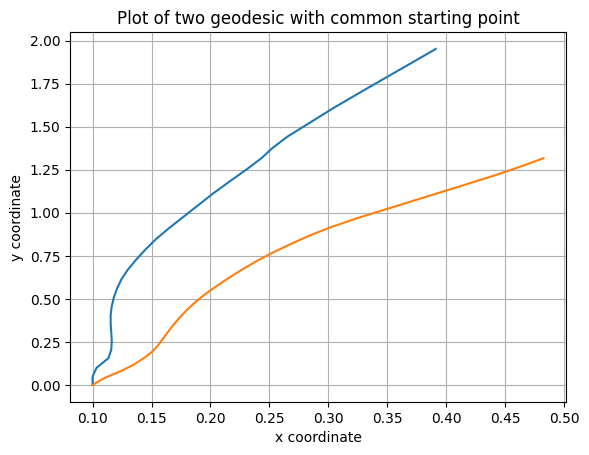

In [96]:
plt.plot(sol2[:, :, 0], sol2[:, :, 1])
#plt.plot(t, solrand[:, :, 1], 'g', label=r'$\theta(t)$')
#plt.legend(loc='best')
#plt.plot( sol.T )
plt.title( "Plot of two geodesic with common starting point")
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.grid()

In [104]:
rand_init_cond = torch.rand(10,4)
rand_init_cond.shape

torch.Size([10, 4])

In [229]:
solrand = rungekutta_new(geod, rand_init_cond, t)
#nans occurr because of bad initial points placement

tensor([[0.0567, 0.5840, 0.0826, 0.3323],
        [0.0060, 0.3587, 0.8147, 0.1808],
        [0.2748, 0.9659, 0.9996, 0.2938],
        [0.6328, 0.5432, 0.1457, 0.6697],
        [0.9873, 0.3369, 0.0672, 0.3472],
        [0.7148, 0.0016, 0.1204, 0.6554],
        [0.5893, 0.8470, 0.1708, 0.6296],
        [0.7700, 0.4462, 0.5202, 0.4734],
        [0.0035, 0.2518, 0.5452, 0.8441],
        [0.2312, 0.2198, 0.0659, 0.9778]])
tensor([[0.0649, 0.6172, 0.0962, 0.3489],
        [0.0875, 0.3768, 0.8578, 0.2221],
        [0.3748, 0.9953, 1.6863, 1.0195],
        [0.6474, 0.6102, 0.1972, 0.7355],
        [0.9940, 0.3716, 0.0587, 0.3412],
        [0.7268, 0.0671, 0.1100, 0.6499],
        [0.6064, 0.9100, 0.1826, 0.6519],
        [0.8220, 0.4935, 0.6010, 0.5688],
        [0.0580, 0.3363, 0.5441, 0.8431],
        [0.2378, 0.3176, 0.0732, 0.9820]])
tensor([[0.0746, 0.6521, 0.1116, 0.3677],
        [0.1733, 0.3990, 0.8981, 0.2580],
        [0.5434, 1.0972, 1.9687, 1.2587],
        [0.6671, 0.6837, 0.3033,

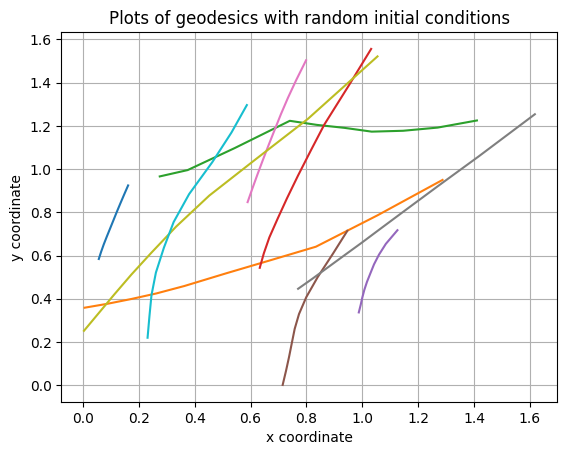

In [230]:
#theese are some 10 random geodesics
#The lenghts are not equal because initial speeds are random and not normalized
plt.plot(solrand[:10, :, 0], solrand[:10, :, 1])
#plt.plot(t, solrand[:, :, 1], 'g', label=r'$\theta(t)$')
#plt.legend(loc='best')
#plt.plot( sol.T )
plt.title( "Plots of geodesics with random initial conditions")
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.grid()

In [105]:
# Let us start at one point u with different speeds v
# we want to draw m geodesics
m = 10
u = torch.tensor([0.10,0.00])
u = u.repeat(m,1)

In [106]:
u

tensor([[0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000],
        [0.1000, 0.0000]])

In [107]:
v = torch.rand(m,2)
vnorm = v.norm(dim=1)
v = (v.T/vnorm).T

torch.Size([10, 2])

In [109]:
v = (v.T/vnorm).T
v

tensor([[0.6035, 0.7973],
        [0.7463, 0.6656],
        [0.8568, 0.5156],
        [0.4977, 0.8673],
        [0.5654, 0.8248],
        [0.4935, 0.8698],
        [0.9914, 0.1307],
        [0.9794, 0.2019],
        [0.7733, 0.6341],
        [0.8434, 0.5373]])

In [110]:
#common initial point and normalized ramdom speed with norm = 1
CommonStartRandSpeed = torch.cat((u,v),1)
CommonStartRandSpeed

tensor([[0.1000, 0.0000, 0.6035, 0.7973],
        [0.1000, 0.0000, 0.7463, 0.6656],
        [0.1000, 0.0000, 0.8568, 0.5156],
        [0.1000, 0.0000, 0.4977, 0.8673],
        [0.1000, 0.0000, 0.5654, 0.8248],
        [0.1000, 0.0000, 0.4935, 0.8698],
        [0.1000, 0.0000, 0.9914, 0.1307],
        [0.1000, 0.0000, 0.9794, 0.2019],
        [0.1000, 0.0000, 0.7733, 0.6341],
        [0.1000, 0.0000, 0.8434, 0.5373]])

In [113]:
t = torch.linspace(0, 1, steps = 31)
solCommonStartRandSpeed = rungekutta_new(geod, CommonStartRandSpeed, t)

tensor([[0.1000, 0.0000, 0.6035, 0.7973],
        [0.1000, 0.0000, 0.7463, 0.6656],
        [0.1000, 0.0000, 0.8568, 0.5156],
        [0.1000, 0.0000, 0.4977, 0.8673],
        [0.1000, 0.0000, 0.5654, 0.8248],
        [0.1000, 0.0000, 0.4935, 0.8698],
        [0.1000, 0.0000, 0.9914, 0.1307],
        [0.1000, 0.0000, 0.9794, 0.2019],
        [0.1000, 0.0000, 0.7733, 0.6341],
        [0.1000, 0.0000, 0.8434, 0.5373]])
tensor([[0.1201, 0.0266, 0.7193, 0.8070],
        [0.1249, 0.0222, 0.8657, 0.6756],
        [0.1286, 0.0172, 0.9700, 0.5251],
        [0.1166, 0.0289, 0.6058, 0.8764],
        [0.1188, 0.0275, 0.6788, 0.8343],
        [0.1164, 0.0290, 0.6012, 0.8788],
        [0.1330, 0.0044, 1.0633, 0.1367],
        [0.1326, 0.0067, 1.0605, 0.2087],
        [0.1258, 0.0211, 0.8921, 0.6440],
        [0.1281, 0.0179, 0.9579, 0.5469]])
tensor([[0.1441, 0.0535, 0.6745, 0.7762],
        [0.1537, 0.0447, 0.8427, 0.6598],
        [0.1609, 0.0347, 0.9735, 0.5275],
        [0.1368, 0.0581, 0.5518,

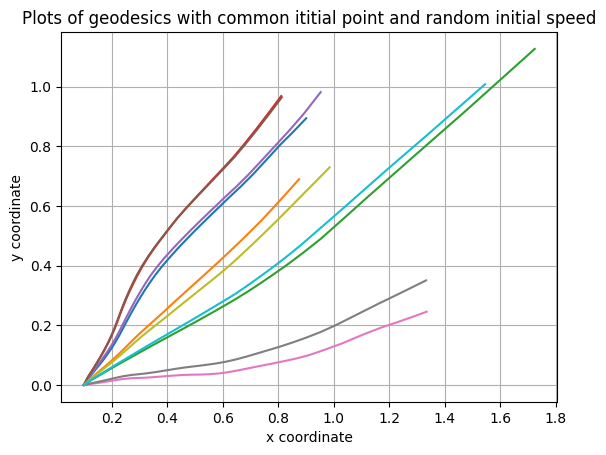

In [120]:
#Why the lenghts are not equal ?
plt.plot(solCommonStartRandSpeed[:, :, 0], solCommonStartRandSpeed[:, :, 1])
plt.title( "Plots of geodesics with common ititial point and random initial speed")
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.grid()

In [124]:
# Let us start at random points u with the same speed v
# we want to draw m geodesics
m = 10
v = torch.tensor([0.00, 0.00,1.00])
v = v.repeat(m,1)
u = torch.rand(m,1)
#unorm = u.norm(dim=1)
#u = (u.T/unorm).T

RandStartComSpeed = torch.cat((u,v),1)
RandStartComSpeed

tensor([[0.6871, 0.0000, 0.0000, 1.0000],
        [0.3083, 0.0000, 0.0000, 1.0000],
        [0.0732, 0.0000, 0.0000, 1.0000],
        [0.9821, 0.0000, 0.0000, 1.0000],
        [0.9810, 0.0000, 0.0000, 1.0000],
        [0.1899, 0.0000, 0.0000, 1.0000],
        [0.6306, 0.0000, 0.0000, 1.0000],
        [0.8814, 0.0000, 0.0000, 1.0000],
        [0.0138, 0.0000, 0.0000, 1.0000],
        [0.0065, 0.0000, 0.0000, 1.0000]])

In [125]:
t = torch.linspace(0, 1, steps = 21)
sol3 = rungekutta_new(geod, RandStartComSpeed, t)

tensor([[0.6871, 0.0000, 0.0000, 1.0000],
        [0.3083, 0.0000, 0.0000, 1.0000],
        [0.0732, 0.0000, 0.0000, 1.0000],
        [0.9821, 0.0000, 0.0000, 1.0000],
        [0.9810, 0.0000, 0.0000, 1.0000],
        [0.1899, 0.0000, 0.0000, 1.0000],
        [0.6306, 0.0000, 0.0000, 1.0000],
        [0.8814, 0.0000, 0.0000, 1.0000],
        [0.0138, 0.0000, 0.0000, 1.0000],
        [0.0065, 0.0000, 0.0000, 1.0000]])
tensor([[ 6.8711e-01,  5.0000e-02,  1.6722e-03,  1.0008e+00],
        [ 3.0831e-01,  5.0000e-02, -3.4521e-02,  9.8089e-01],
        [ 7.3245e-02,  5.0000e-02,  6.9979e-02,  1.0059e+00],
        [ 9.8213e-01,  5.0000e-02, -1.2936e-02,  9.9504e-01],
        [ 9.8096e-01,  5.0000e-02,  1.1314e-02,  1.0043e+00],
        [ 1.8991e-01,  5.0000e-02, -6.4886e-02,  9.6023e-01],
        [ 6.3057e-01,  5.0000e-02,  3.7062e-04,  1.0002e+00],
        [ 8.8137e-01,  5.0000e-02, -3.1017e-02,  9.8867e-01],
        [ 1.3767e-02,  5.0000e-02,  4.1047e-02,  9.9664e-01],
        [ 6.4958e-03,

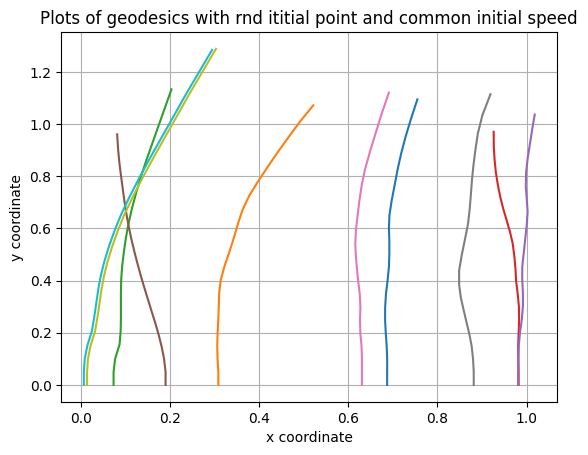

In [126]:
plt.plot(sol3[:, :, 0], sol3[:, :, 1])
plt.title( "Plots of geodesics with rnd ititial point and common initial speed")
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.grid()

## Checking that there is no error in metric computation

In [12]:
# Fast computation of Frobenious norm on the grid without borders
Newfrob = metric.norm(dim=(1,2)).view(numsteps,numsteps)
Newfrob = Newfrob[1:-1,1:-1].transpose(0,1)

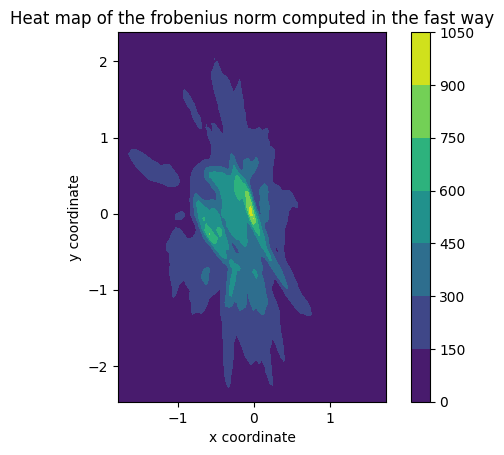

In [13]:
#Heat map of the frobenius norm
h = plt.contourf(xs[1:-1], ys[1:-1], Newfrob)
plt.title('Heat map of the frobenius norm computed in the fast way')
plt.xlabel( "x coordinate")
plt.ylabel( "y coordinate")
plt.axis('scaled')
plt.colorbar()
plt.show()

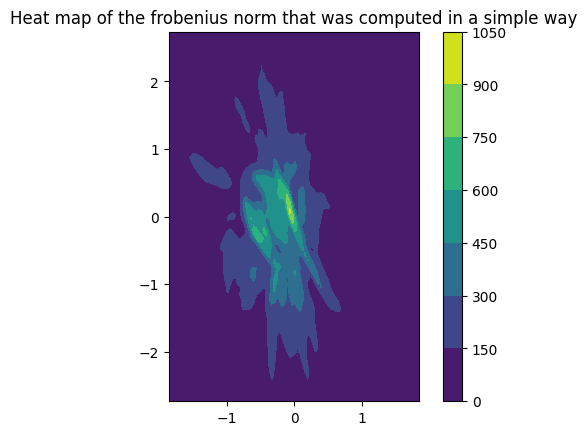

In [245]:
#Heat map of the frobenius norm that was computed in a simple way

h = plt.contourf(xs[1:-1], ys[1:-1], FrobNormGrid[1:-1,1:-1])
plt.title('Heat map of the frobenius norm that was computed in a simple way')
#h = plt.contourf(xs, ys, FrobNormGrid)
plt.axis('scaled')
plt.colorbar()
plt.show()

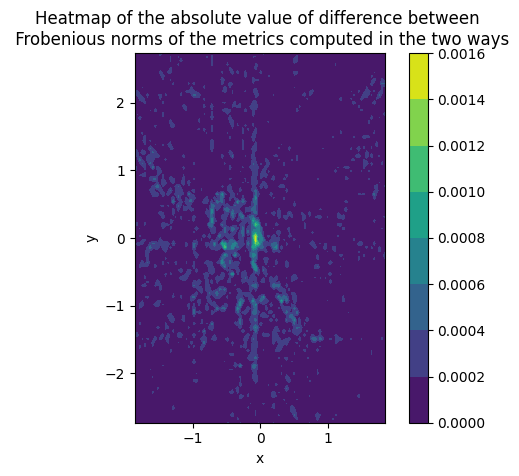

In [246]:
#Heat map of the frobenius norm of the difference
h = plt.contourf(xs[1:-1], ys[1:-1], abs(Newfrob - FrobNormGrid[1:-1,1:-1]))
plt.axis('scaled')
plt.title('Heatmap of the absolute value of difference between \n Frobenious norms of the metrics computed in the two ways')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

# We can see that there are three ways to compute the metrics and the simplest pointwise way coverges to the precise way 
# while coinciding with the fast way which means that the fast way should also convegre to the precise way as the grid gets more and more dense

## Trying autograd

In [90]:
# the decoder takes a tensor containing points of latent space
#mypoint = torch.tensor(latent[5].view(1,2),requires_grad = True)
mypoint = torch.tensor([[0.,0.]],requires_grad = True)
#so the entree of the decoder has to be of shape (number of points, 2)
mypoint.shape

torch.Size([1, 2])

In [91]:
Q = decoder(mypoint)

In [92]:
Q.shape

torch.Size([1, 1, 28, 28])

In [94]:
external_grad = torch.ones(Q.shape)
Q.backward(gradient=external_grad)

In [96]:
mypoint.grad

tensor([[-20.3993, -56.6439]])

In [102]:
# Jacobian
# Very slow
#inputs = mypoint
output = torch.autograd.functional.jacobian(decoder, latent)

# Three ways to compute metrics at a certain point

In [88]:
tgrid.shape

torch.Size([10000, 2])

In [201]:
# let us choose some point and find its index
find_nearest_index(tgrid, torch.tensor([- 0.2, - 1.1]))

3045

In [202]:
# jacobian at one point
mypoint = (tgrid[3045].view(1,2)).clone().detach().requires_grad_(True)
inputs = mypoint
jac = torch.autograd.functional.jacobian(decoder, inputs)

In [203]:
myjac = jac.view(28*28,2)

In [204]:
myjac.shape

torch.Size([784, 2])

In [205]:
#precise way
torch.matmul(myjac.t(),myjac)

tensor([[143.4460, -11.4526],
        [-11.4526,  80.0291]])

In [206]:
print(hx, hy)

0.03811896208560828 0.05637203563343395


In [207]:
#simple but slow
my_g_upd(tgrid[3045],hx,hy)

tensor([[110.6639,  -8.4012],
        [ -8.4012,  69.8096]])

In [208]:
#the fastest way
metric[3045]

tensor([[110.6639,  -8.4013],
        [ -8.4013,  69.8095]])

In [209]:
# another slow fay
myMetricSlow = MetricSlow.view(numsteps,numsteps,2,2).transpose(0,1)
myMetricSlow.shape

torch.Size([100, 100, 2, 2])

In [210]:
myMetricSlow = myMetricSlow.reshape(numsteps*numsteps,2,2)
myMetricSlow[3045]

tensor([[110.6638,  -8.4012],
        [ -8.4012,  69.8096]])

In [ ]:
#we can see that the error is ~10% on a grid 100x100. But as h - > 0 it will go to 0